In [1]:
import sys; print(sys.version)

3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]


In [2]:
!pip install --upgrade pip

  Using cached pip-25.1-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Users\avane\Desktop\brain_tumor_detection_CNN\myenv-311\Scripts\python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install tensorflow


[notice] A new release of pip available: 22.3 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from IPython.display import clear_output
!pip install kaggle imutils plotly opencv-python matplotlib scikit-learn
clear_output()

In [5]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

# from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.vgg16 import VGG16, preprocess_input
# from keras import layers
# from keras.models import Model, Sequential
# from keras.optimizers import Adam, RMSprop
# from keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping


init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [ ]:
import zipfile

# Download datasets
!kaggle datasets download -d gaborfodor/keras-pretrained-models
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

# Unzip the datasets
with zipfile.ZipFile("keras-pretrained-models.zip", 'r') as zip_ref:
    zip_ref.extractall("keras_pretrained_models")

with zipfile.ZipFile("brain-mri-images-for-brain-tumor-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("Brain_Tumor_Detection")

print("Data source import complete.")


Dataset URL: https://www.kaggle.com/datasets/gaborfodor/keras-pretrained-models
License(s): CC-BY-SA-4.0
keras-pretrained-models.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Data source import complete.


In [6]:
import os

# Create folders
folders = [
    'TRAIN/YES', 'TRAIN/NO',
    'TEST/YES', 'TEST/NO',
    'VAL/YES', 'VAL/NO'
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("Folders created successfully.")


Folders created successfully.


In [7]:
# import shutil
# IMG_PATH = './brain_tumor_dataset/'
# # split the data by train/val/test
# for CLASS in os.listdir(IMG_PATH):
#     if not CLASS.startswith('.'):
#         IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
#         for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
#             img = IMG_PATH + CLASS + '/' + FILE_NAME
#             if n < 5:
#                 shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
#             elif n < 0.8*IMG_NUM:
#                 shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
#             else:
#                 shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [8]:
import os
import shutil
import random

IMG_PATH = './Brain_Tumor_Detection/'
output_dirs = ['TRAIN', 'VAL', 'TEST']

# Create directories if not present
for split in output_dirs:
    for label in ['YES', 'NO']:
        os.makedirs(f'{split}/{label}', exist_ok=True)

# Set your desired split ratios
test_ratio = 0.2
val_ratio = 0.2

for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        full_class_path = os.path.join(IMG_PATH, CLASS)
        all_images = [f for f in os.listdir(full_class_path) if not f.startswith('.')]
        random.shuffle(all_images)

        total = len(all_images)
        test_size = int(total * test_ratio)
        val_size = int(total * val_ratio)

        test_imgs = all_images[:test_size]
        val_imgs = all_images[test_size:test_size + val_size]
        train_imgs = all_images[test_size + val_size:]

        for fname in test_imgs:
            shutil.copy(os.path.join(full_class_path, fname), f'TEST/{CLASS.upper()}/{fname}')

        for fname in val_imgs:
            shutil.copy(os.path.join(full_class_path, fname), f'VAL/{CLASS.upper()}/{fname}')

        for fname in train_imgs:
            shutil.copy(os.path.join(full_class_path, fname), f'TRAIN/{CLASS.upper()}/{fname}')


In [9]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    img = cv2.imread(os.path.join(dir_path, path, file))
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        X.append(img)
                        y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [10]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:14<00:00,  7.18s/it]


1800 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


600 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:04<00:00,  2.48s/it]

600 images loaded from VAL/ directory.


In [11]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [12]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

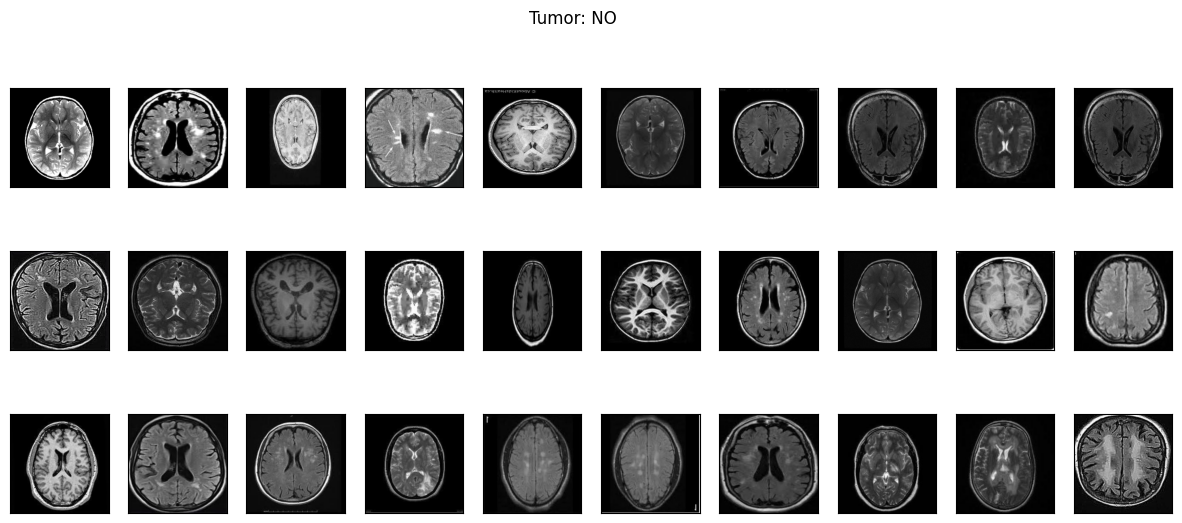

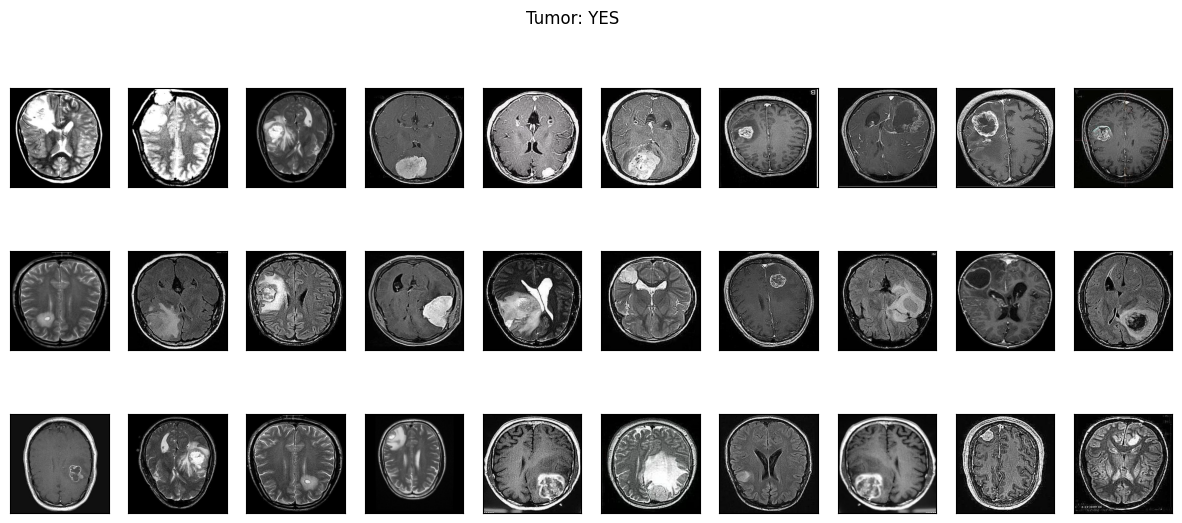

In [13]:
plot_samples(X_train, y_train, labels, 30)

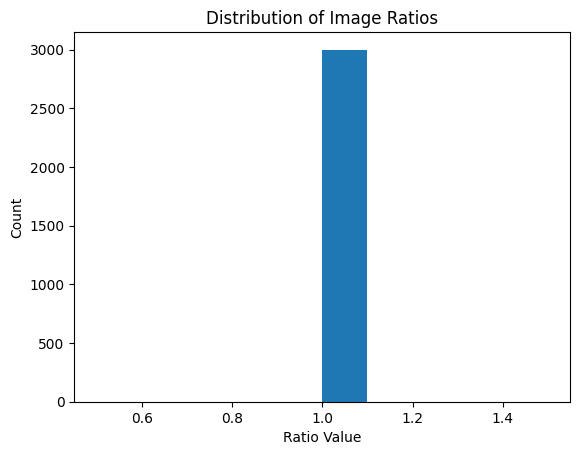

In [14]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])

plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [15]:
# def crop_imgs(set_name, add_pixels_value=0):
#     """
#     Finds the extreme points on the image and crops the rectangular out of them
#     """
#     set_new = []
#     for img in set_name:
#         gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         gray = cv2.GaussianBlur(gray, (5, 5), 0)

#         # threshold the image, then perform a series of erosions +
#         # dilations to remove any small regions of noise
#         thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
#         thresh = cv2.erode(thresh, None, iterations=2)
#         thresh = cv2.dilate(thresh, None, iterations=2)

#         # find contours in thresholded image, then grab the largest one
#         cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         cnts = imutils.grab_contours(cnts)
#         c = max(cnts, key=cv2.contourArea)

#         # find the extreme points
#         extLeft = tuple(c[c[:, :, 0].argmin()][0])
#         extRight = tuple(c[c[:, :, 0].argmax()][0])
#         extTop = tuple(c[c[:, :, 1].argmin()][0])
#         extBot = tuple(c[c[:, :, 1].argmax()][0])

#         ADD_PIXELS = add_pixels_value
#         new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
#         set_new.append(new_img)

#     return np.array(set_new)

def crop_imgs(set_name, add_pixels_value=0, final_size=(224,224)):
    set_new = []
    
    for img in tqdm(set_name):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        if len(cnts) == 0:
            # if no contours found, skip this image
            continue

        c = max(cnts, key=cv2.contourArea)

        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        cropped = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

        cropped_resized = cv2.resize(cropped, final_size, interpolation=cv2.INTER_AREA)
        set_new.append(cropped_resized)

    return np.array(set_new)


In [16]:
img = cv2.imread('./Brain_Tumor_Detection/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

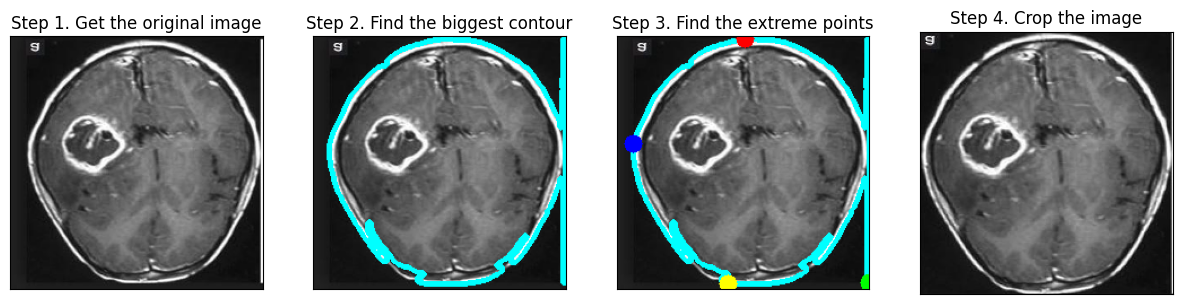

In [17]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [18]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

100%|██████████| 600/600 [00:00<00:00, 1828.46it/s]


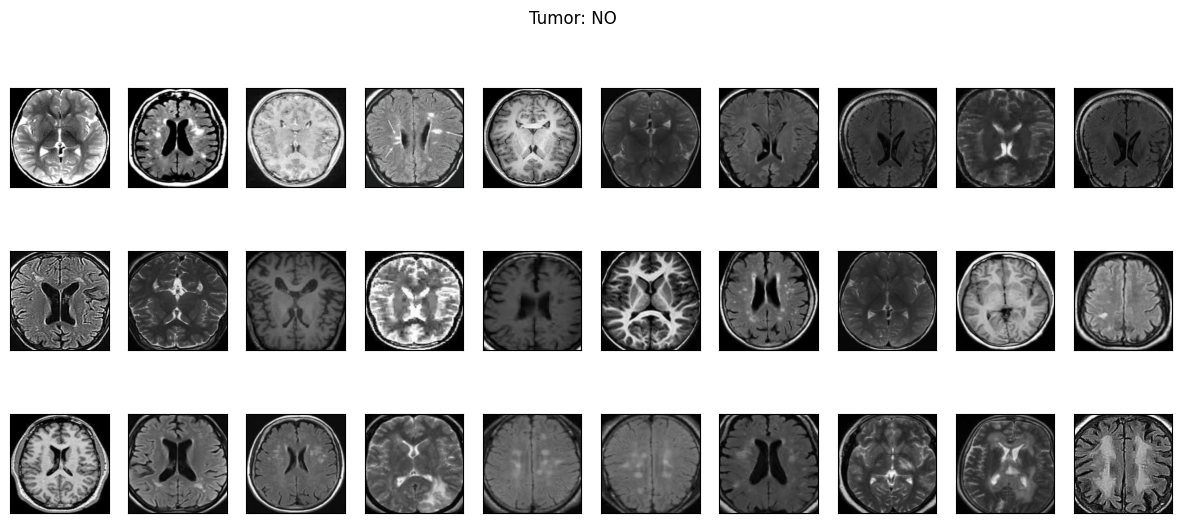

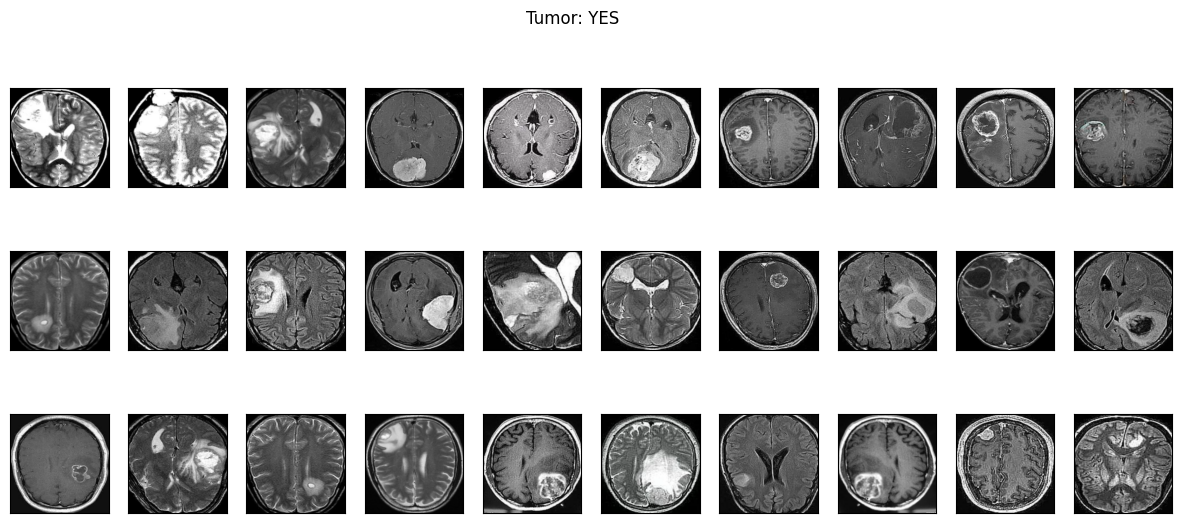

In [19]:
plot_samples(X_train_crop, y_train, labels, 30)

In [20]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [21]:
# saving new images to the folder
import os

# List of folders you want to create
folders = [
    'TRAIN_CROP/YES', 'TRAIN_CROP/NO',
    'TEST_CROP/YES', 'TEST_CROP/NO',
    'VAL_CROP/YES', 'VAL_CROP/NO'
]

# Create each folder if it doesn't exist
for folder in folders:
    os.makedirs(folder, exist_ok=True)


save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [22]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-16 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [23]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-107.68..150.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.68..115.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..147.061].
Clipping input data 

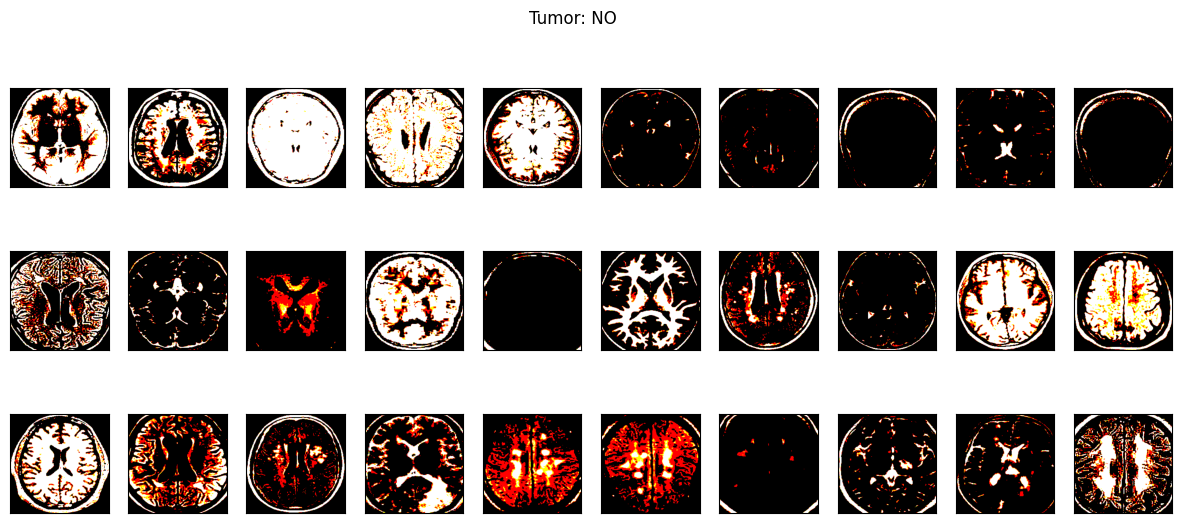

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..150.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data 

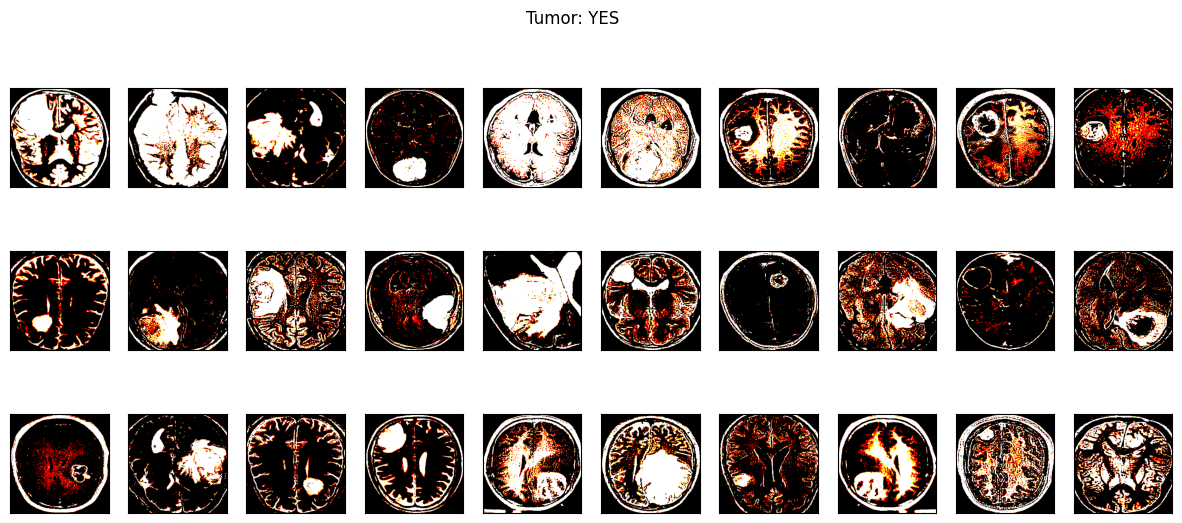

In [24]:
plot_samples(X_train_prep, y_train, labels, 30)

In [25]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [27]:
os.mkdir('preview')
x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

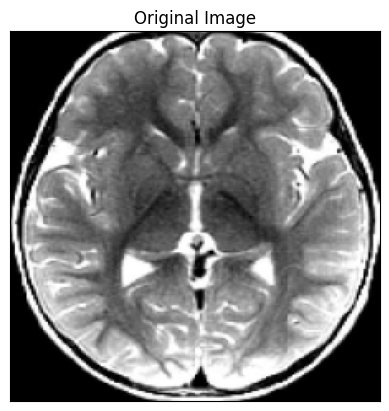

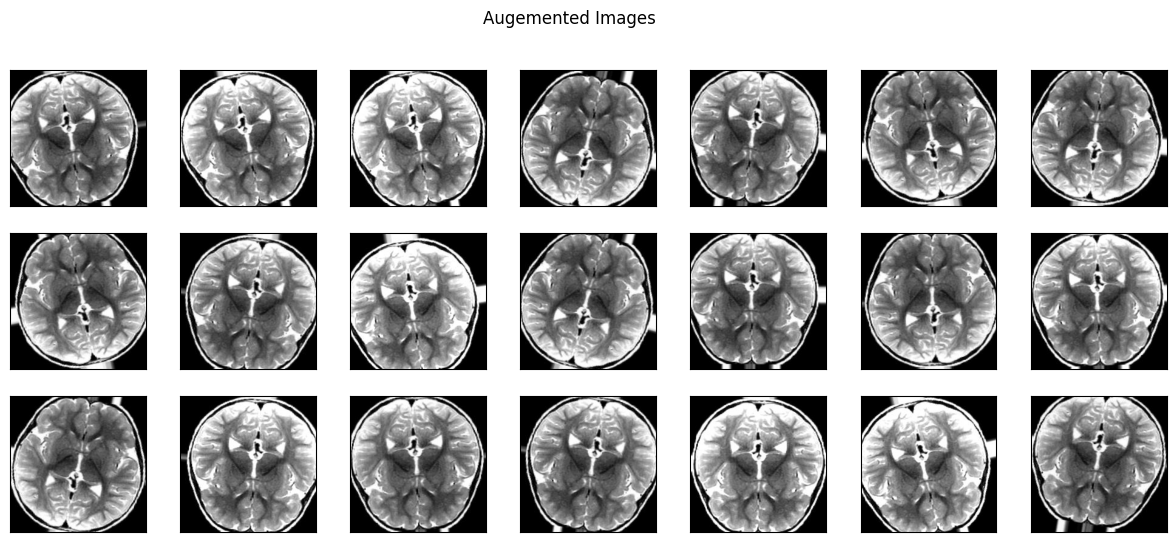

In [28]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [29]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1800 images belonging to 2 classes.


Found 600 images belonging to 2 classes.


In [30]:
import os
print(os.path.exists('./keras_pretrained_models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'))

True


In [31]:
# load base model
vgg16_weight_path = './keras_pretrained_models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

In [32]:

from tensorflow.keras.optimizers import RMSprop

NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),  # <-- FIX: use learning_rate instead of lr
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[es]
)


c:\Users\avane\Desktop\brain_tumor_detection_CNN\myenv-311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.5783 - loss: 5.1156 - val_accuracy: 0.8209 - val_loss: 1.1209
Epoch 2/30
 1/56 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - accuracy: 0.6562 - loss: 2.5084

c:\Users\avane\Desktop\brain_tumor_detection_CNN\myenv-311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 627ms/step - accuracy: 0.6562 - loss: 2.5084 - val_accuracy: 0.8108 - val_loss: 1.1199
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.7049 - loss: 2.8915 - val_accuracy: 0.8581 - val_loss: 0.8177
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 607ms/step - accuracy: 0.7188 - loss: 2.5128 - val_accuracy: 0.8598 - val_loss: 0.8093
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7558 - loss: 2.1328 - val_accuracy: 0.8970 - val_loss: 0.6972
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 608ms/step - accuracy: 0.7812 - loss: 1.6107 - val_accuracy: 0.8902 - val_loss: 0.7015
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7583 - loss: 2.0745 - val_accuracy: 0.8902 - val_loss: 0.8205
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 607ms/step - accuracy: 0.7812 - loss: 2.2680 - val_accuracy: 0.8936 - val_loss: 0.6706
Epoch 9/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7930 - loss: 1.7561 - val_accuracy: 0.9054 - val_

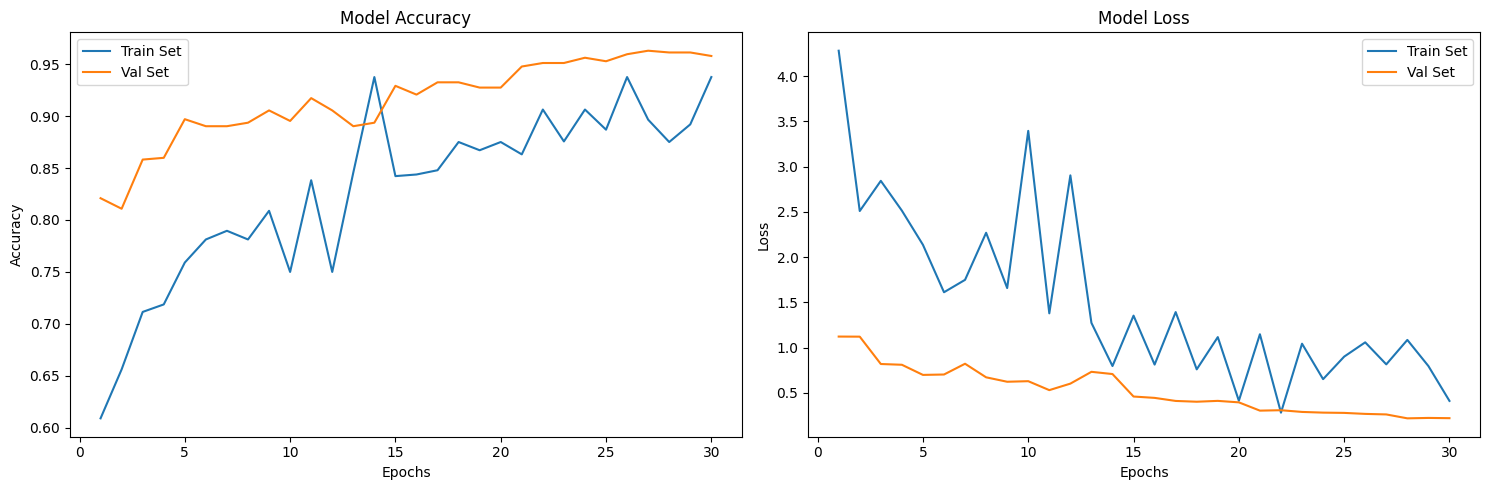

In [34]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [35]:
print(history.history.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
Val Accuracy = 0.96


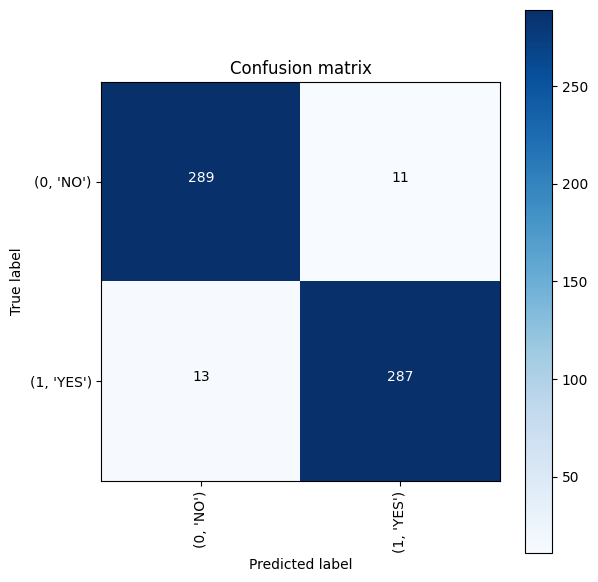

In [36]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
Test Accuracy = 0.96


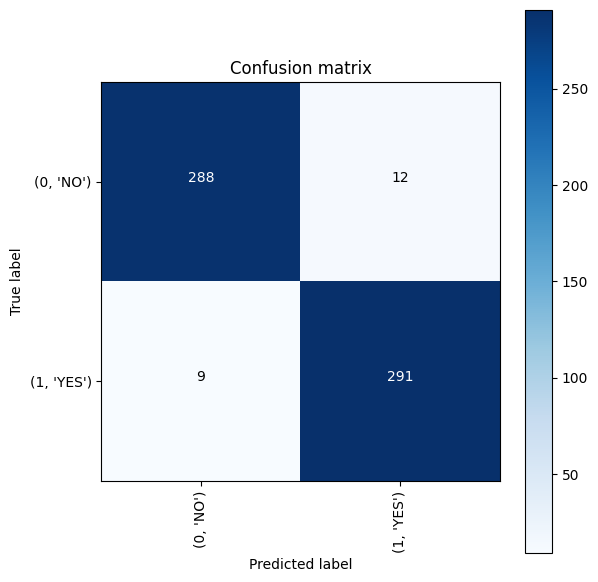

In [37]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

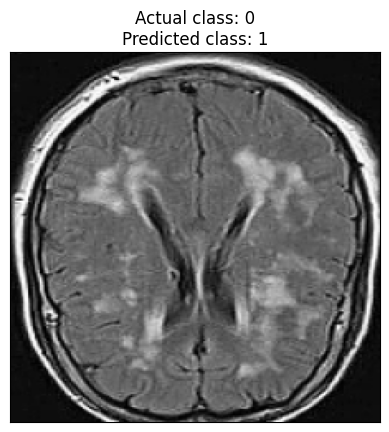

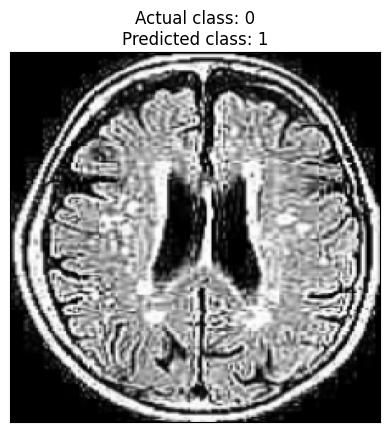

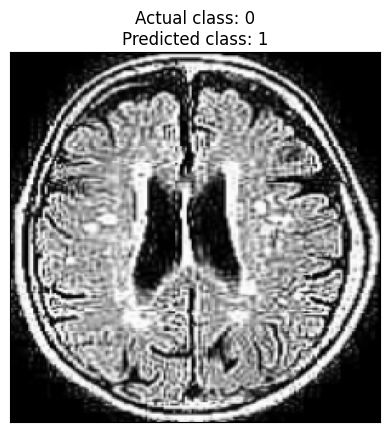

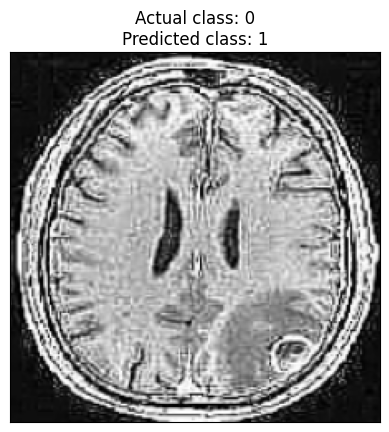

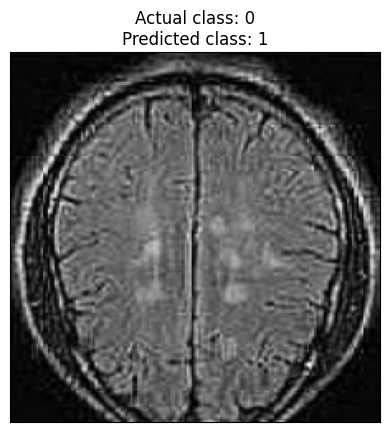

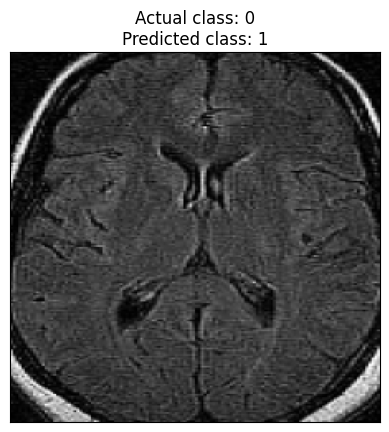

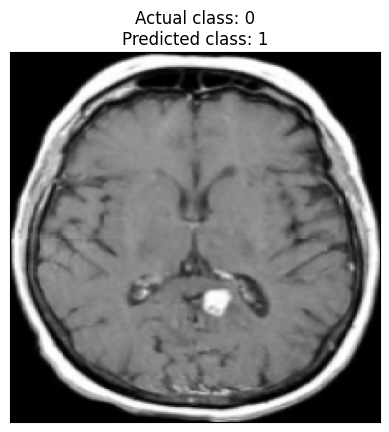

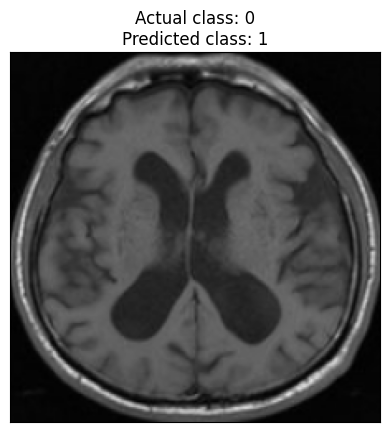

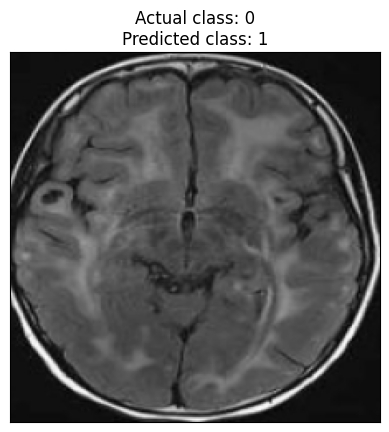

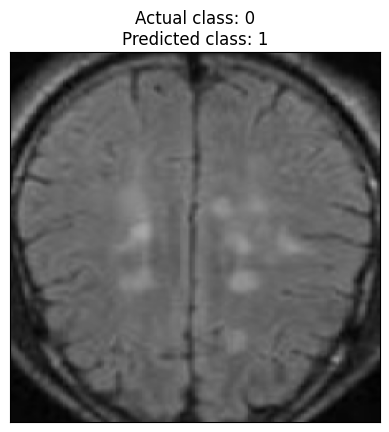

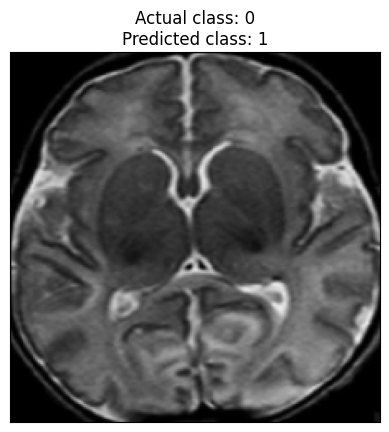

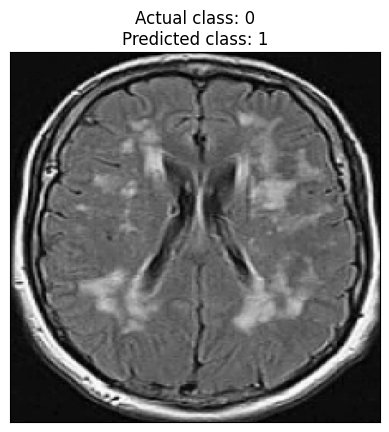

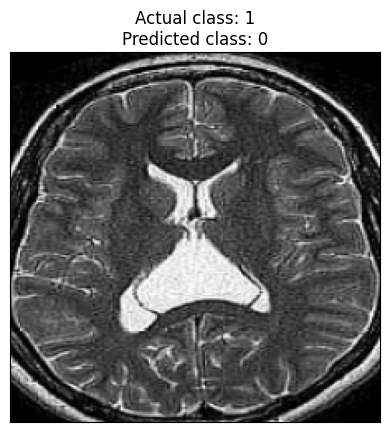

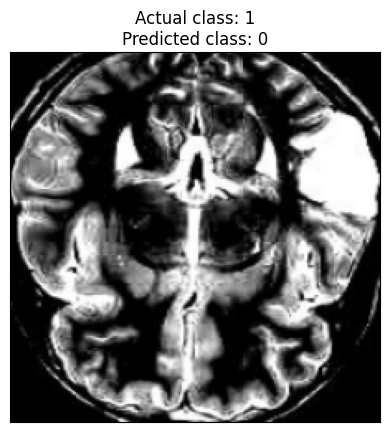

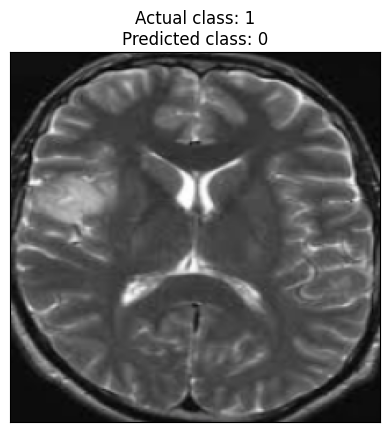

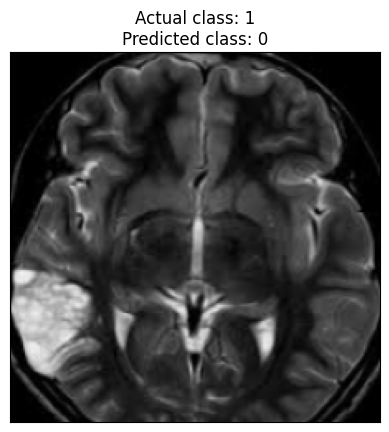

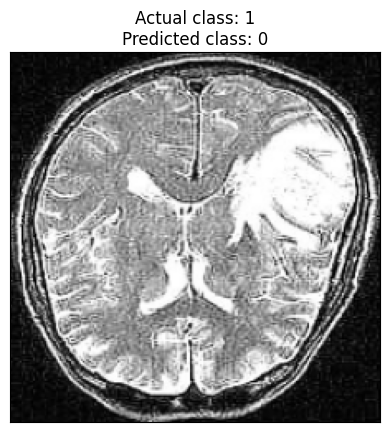

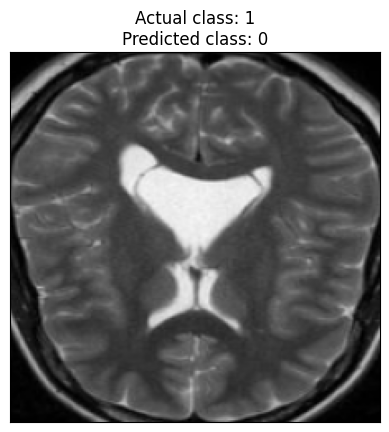

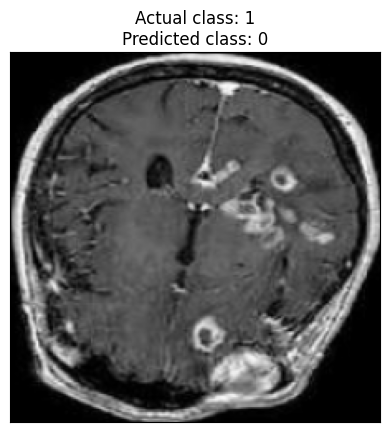

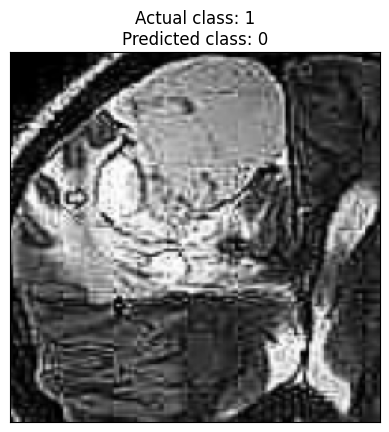

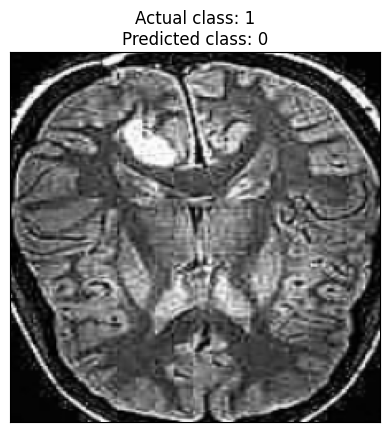

In [38]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

In [40]:
prob_pred = model.predict(X_test_prep)

19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step


In [41]:
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test, predictions),4))
print('Precision score is :', np.round(metrics.precision_score(y_test, predictions, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test, predictions, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test, predictions, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test, prob_pred,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, predictions),4))

print('\t\tClassification Report:\n', metrics.classification_report(y_test, predictions))

Accuracy score is : 0.965
Precision score is : 0.965
Recall score is : 0.965
F1 Score is : 0.965
ROC AUC Score is : 0.9891
Cohen Kappa Score: 0.93
		Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       300
           1       0.96      0.97      0.97       300

    accuracy                           0.96       600
   macro avg       0.97      0.96      0.96       600
weighted avg       0.97      0.96      0.96       600

